# WiDS 2025
### Sex Patterns in ADHD

### Import

In [1]:
import pandas as pd
import numpy as np
import math


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
from sklearn.linear_model import MultiTaskElasticNetCV


In [2]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [3]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [4]:
train = connectome_train.merge(quan_train, on= 'participant_id').merge(cat_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [5]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

In [6]:
# Explore Null data
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,360
PreInt_Demos_Fam_Child_Ethnicity,11


In [7]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

'null_index = train[train.isnull().any(axis=1)].index\n\ntrain = train[~train.index.isin(null_index)]\nlabel = label[~label.index.isin(null_index)]'

In [12]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [13]:
label.Sex_F.value_counts()
# 797 M, 416 F

Sex_F
0    797
1    416
Name: count, dtype: int64

In [14]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

Sex_F,0,1
ADHD_Outcome,,
0,0.178071,0.136851
1,0.478978,0.206101


In [15]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

Sex_F,0,1
ADHD_Outcome,,
0,216,166
1,581,250


In [16]:
connectome_train.set_index('participant_id', inplace= True)

In [17]:
df = connectome_train.iloc[:,:5]

In [18]:
df

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn
participant_id,,,,,
70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221
WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899
4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085
obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431
s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139
...,...,...,...,...,...
kTurROKp5YHQ,0.022932,0.024830,-0.006514,0.021070,0.093365
FCRyMz9O6yCq,0.047078,0.135955,0.144366,0.054938,0.065760
vm2P1hmAY1hl,0.094541,0.145280,0.061964,0.030562,0.078278


# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Preprocessing
A pipeline that transform categorical into one-hot code, and quant data into a standard scaler

In [19]:
# Remove 2 features with null
train = train.drop(['MRI_Track_Age_at_Scan', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1)
categorical_features = list(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis= 1).columns)
numeric_features = train.drop(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1).columns, axis = 1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Train - test split


In [20]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [21]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count


In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(849, 19925)
(364, 19925)
(849, 2)
(364, 2)


### Visual call-out Functions

In [23]:
def model_result(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print('Accuracy: ', accuracy)
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")
    print('f1: ', f1_score(y_test, y_pred))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Logistic Regression for each task

f1 score of ADHD Log Regression with L1 : 0.60
Accuracy:  0.6016483516483516
Sensitivity (Recall/True Positive Rate): 0.80
Specificity (True Negative Rate): 0.17
f1:  0.732965009208103


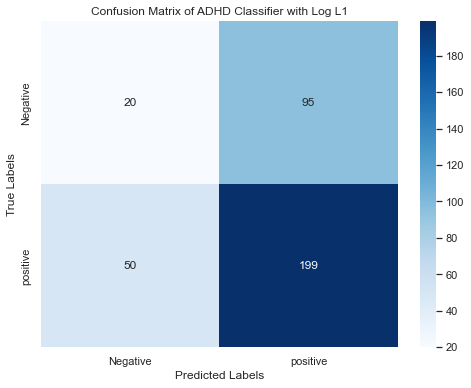

In [27]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', (LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train.iloc[:,0])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
#f1 = f1_score(y_test.iloc[:,0],y_pred, average = 'micro')
print(f'f1 score of ADHD Log Regression with L1 : {f1:.2f}')
model_result(y_test['ADHD_Outcome'], y_pred, "ADHD Classifier with Log L1")

In [28]:
coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

Sorted Coefficients:
4throw_126thcolumn: 0.4467
28throw_186thcolumn: -0.3664
78throw_162thcolumn: -0.3405
43throw_79thcolumn: -0.3236
60throw_143thcolumn: 0.3130
16throw_162thcolumn: 0.3068
127throw_156thcolumn: -0.2959
71throw_135thcolumn: -0.2946
84throw_183thcolumn: -0.2936
10throw_162thcolumn: -0.2910
12throw_89thcolumn: 0.2876
7throw_98thcolumn: -0.2648
46throw_137thcolumn: 0.2621
26throw_96thcolumn: 0.2522
95throw_156thcolumn: -0.2512
72throw_133thcolumn: 0.2505
131throw_163thcolumn: -0.2476
16throw_154thcolumn: -0.2439
108throw_129thcolumn: -0.2385
36throw_66thcolumn: 0.2377
106throw_194thcolumn: -0.2340
94throw_128thcolumn: -0.2288
44throw_89thcolumn: -0.2264
68throw_150thcolumn: -0.2198
13throw_172thcolumn: -0.2157
13throw_174thcolumn: 0.2097
3throw_176thcolumn: -0.2090
52throw_175thcolumn: 0.2069
4throw_104thcolumn: 0.2057
115throw_142thcolumn: -0.2057
41throw_169thcolumn: -0.2048
144throw_181thcolumn: -0.2024
21throw_147thcolumn: 0.2002
19throw_135thcolumn: 0.1989
24throw_14

f1 score of Sex Log Regression with L1 : 0.59
Accuracy:  0.5934065934065934
Sensitivity (Recall/True Positive Rate): 0.22
Specificity (True Negative Rate): 0.80
f1:  0.28155339805825247


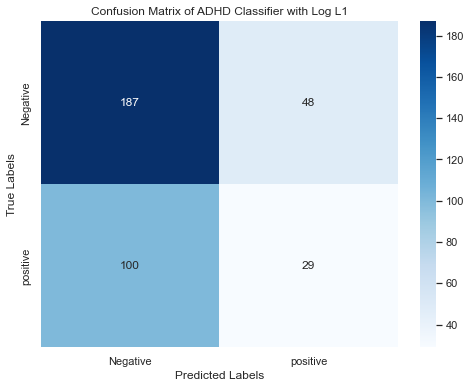

Sorted Coefficients:
18throw_189thcolumn: -0.3917
67throw_116thcolumn: 0.3583
9throw_49thcolumn: -0.3431
85throw_182thcolumn: 0.3343
75throw_184thcolumn: 0.3193
4throw_195thcolumn: -0.3156
136throw_154thcolumn: -0.3075
64throw_73thcolumn: 0.2850
67throw_75thcolumn: -0.2844
133throw_156thcolumn: 0.2747
48throw_141thcolumn: 0.2680
12throw_89thcolumn: 0.2659
39throw_189thcolumn: 0.2625
56throw_120thcolumn: 0.2612
125throw_158thcolumn: 0.2612
91throw_105thcolumn: 0.2486
91throw_181thcolumn: -0.2469
88throw_129thcolumn: 0.2426
21throw_29thcolumn: -0.2419
59throw_62thcolumn: 0.2378
6throw_12thcolumn: 0.2374
4throw_158thcolumn: -0.2326
12throw_158thcolumn: -0.2300
70throw_123thcolumn: -0.2296
108throw_185thcolumn: 0.2277
34throw_124thcolumn: -0.2267
43throw_64thcolumn: 0.2246
45throw_178thcolumn: -0.2226
120throw_192thcolumn: 0.2220
81throw_163thcolumn: -0.2188
69throw_129thcolumn: 0.2183
82throw_97thcolumn: 0.2136
144throw_188thcolumn: -0.2123
72throw_186thcolumn: -0.2116
31throw_86thcolumn:

In [29]:
pipeline.fit(x_train, y_train.iloc[:,1])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test.iloc[:,1],y_pred, average = 'micro')
print(f'f1 score of Sex Log Regression with L1 : {f1:.2f}')
model_result(y_test['Sex_F'], y_pred, "ADHD Classifier with Log L1")

coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

### Multi-output
Perform the same model for both tasks

In [30]:
# Multi-output model for log classifier with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train)

model = pipeline.named_steps['classifier']

y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test,y_pred, average = 'micro')
print(f'f1 score of Multi-output Log Regression with L1 : {f1:.2f}')

f1 score of Multi-output Log Regression with L1 : 0.61


Log while produce about less then 0.6 acc for both classes which is a bit over random guess, it produce extremely low f1 score for Gender.

### Multi-task Models
